# Ordinary Exam 2025 - Asset Allocation Study

# Guided Solution


# Packages

Imported functions and modules are used for solving the exam.  

In [180]:

import numpy as np
import pandas as pd
from matplotlib.lines import lineStyles

# statistical libraries
from scipy.stats import norm, multivariate_normal
from scipy import stats

# optimization functions
from scipy.optimize import minimize
import cvxpy as cp

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# typing
from typing import Union


"""
Own functionality
"""

# statistical functions
from codelib.statistics import moments

# risk metrics
import codelib.portfolio_optimization.risk_metrics as rm

# plotting functionality
from codelib.visualization.base import fan_chart

# entropy pooling
from codelib.statistics import fully_flexible_views as ffv

# Problem 1: Asset Allocation Study

## Modelling the term structure of interest rates

### Bootstrapping yield curves from observed market data



In [96]:
# load fixed income data
df_fixed_income = pd.read_csv('fixed_income_data.csv', index_col=0)

<Axes: >

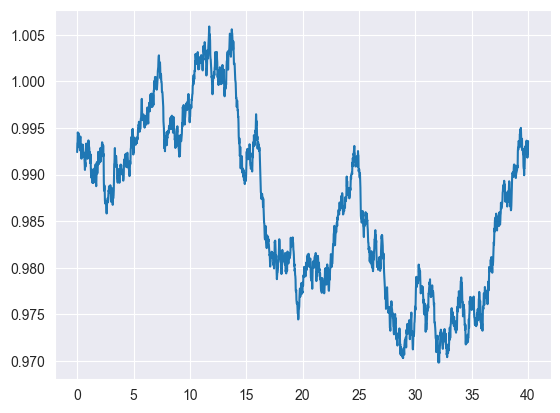

In [97]:
df_fixed_income["3M ZCB"].plot()

In [98]:
"""
build cash flow matrix for bootstrapping zero-coupon curve
"""

cash_flow_time_points = np.array([0.25] + list(range(1, 11)))

# allocate cash flow matrix
cash_flow_matrix = np.zeros((11, 11))

# fill element corresponding to 3M ZCB
cash_flow_matrix[0, 0] = 1

# coupon rate for bullet bonds
coupon_rate = 0.06

# fill elements corresponding to bullet bonds
bullet_bond_cash_flow_matrix = np.tri(10) * coupon_rate * 1 + np.eye(10) * 1
cash_flow_matrix[1:11, 1:11] = bullet_bond_cash_flow_matrix

In [99]:
cash_flow_matrix

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 1.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.06, 1.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.06, 0.06, 1.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.06, 0.06, 0.06, 1.06, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.06, 0.06, 0.06, 0.06, 1.06, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 1.06, 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 1.06, 0.  , 0.  ],
       [0.  , 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 1.06, 0.  ],
       [0.  , 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 1.06]])

In [100]:
"""
Bootstrap curve for each point in time
"""

# obtain discount factors by bootstrapping
df_discount_factors = (np.linalg.inv(cash_flow_matrix) @ df_fixed_income.T).T
df_discount_factors.columns = cash_flow_time_points

# obtain cont. compounded zero rates
df_zero_rates = -np.log(df_discount_factors) / cash_flow_time_points

In [101]:
df_discount_factors.head()

,0.25,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00
0.00000,0.992406,0.965099,0.941864,0.890949,0.857594,0.813557,0.789896,0.761728,0.709405,0.681692,0.680147
0.01924,0.993377,0.971306,0.943432,0.901560,0.887406,0.847711,0.801370,0.769783,0.738664,0.697936,0.666407
0.03848,0.993435,0.972878,0.940567,0.911266,0.879369,0.845851,0.813397,0.759745,0.755635,0.718940,0.675475
0.05772,0.994518,0.971686,0.949740,0.925004,0.885204,0.858555,0.824495,0.801074,0.766497,0.741105,0.699214
0.07696,0.994356,0.977212,0.947845,0.922002,0.875793,0.864701,0.814865,0.800316,0.752293,0.711933,0.730006


In [102]:
df_zero_rates.head()

,0.25,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00
0.00000,0.030490,0.035524,0.029947,0.038489,0.038406,0.041268,0.039309,0.038881,0.042916,0.042575,0.038545
0.01924,0.026580,0.029114,0.029115,0.034543,0.029863,0.033043,0.036905,0.037378,0.037864,0.039959,0.040585
0.03848,0.026346,0.027497,0.030636,0.030974,0.032138,0.033482,0.034423,0.039253,0.035025,0.036664,0.039234
0.05772,0.021989,0.028723,0.025783,0.025986,0.030484,0.030501,0.032164,0.031686,0.033241,0.033290,0.035780
0.07696,0.022639,0.023052,0.026782,0.027069,0.033156,0.029074,0.034122,0.031821,0.035579,0.037752,0.031470


<Axes: >

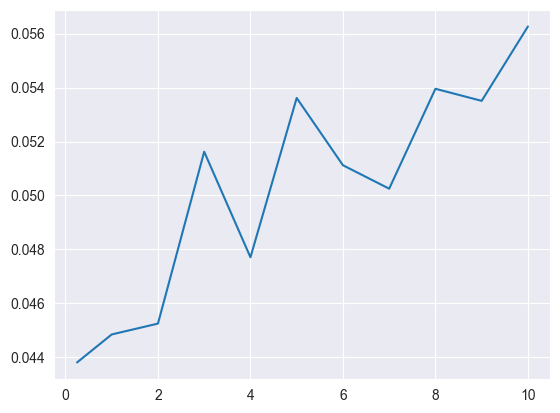

In [103]:
df_zero_rates.iloc[75, :].plot()

### Important observations regarding the data generating process

Yields are almost perfectly correlated across maturities, which indicates that one factor drives the yield curve dynamics!

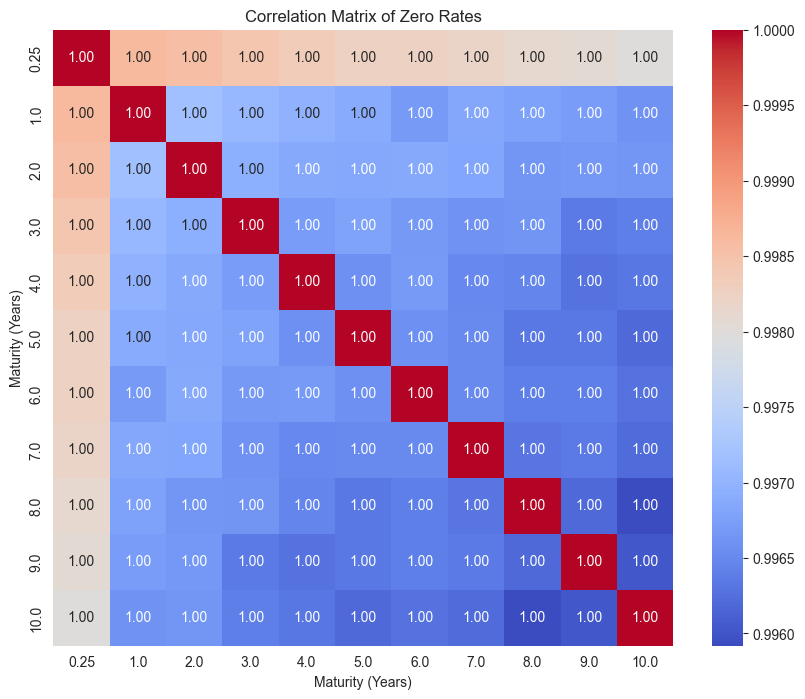

In [104]:
"""
Correlation matrix of zero rates
"""

# calculate correlation matrix
corr_matrix_zero_rates = df_zero_rates.corr()

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_zero_rates, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=cash_flow_time_points, yticklabels=cash_flow_time_points)
plt.xlabel('Maturity (Years)');
plt.ylabel('Maturity (Years)');
plt.title('Correlation Matrix of Zero Rates');

Yield changes appears to be normally distributed, which is consistent with the Vasicek model assumption of normally distributed interest rates!

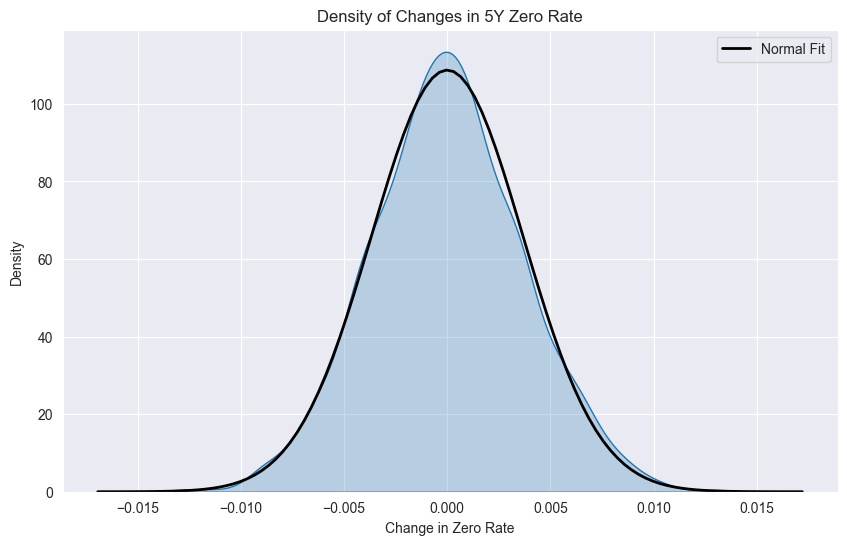

In [105]:
"""
Plot density of changes in 5Y zero rates
"""

zero_rates_to_plot = df_zero_rates.iloc[:, 5]
change_zero_rates_to_plot = zero_rates_to_plot.diff().dropna()

plt.figure(figsize=(10, 6))
# plot density of zero rates
sns.kdeplot(change_zero_rates_to_plot, fill=True)
# add normal fit
mu, std = norm.fit(change_zero_rates_to_plot)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Fit')
plt.title('Density of Changes in 5Y Zero Rate')
plt.xlabel('Change in Zero Rate')
plt.ylabel('Density')
plt.legend()



### Estimating dynamics of the yield curve

It is possible to model the yield curve using different approaches. The underlying data is generated using a Vacicek model with measurement error added to the observed zero rates, but not the 3M zero rate.

I apply a Chen-Scott approach to estimate the model parameters in a one-factor Vasicek model with i.i.d. and constant measurement error.

In [106]:
"""
Helper functions
"""

def calculate_zero_coupon_price(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                sigma: float):

    """
    Computes the zero coupon yield for a given maturity and short rate using the Vasicek model.

    Parameters
    ----------
    time_to_maturity:
        time to maturity of the zero coupon bond.
    initial_short_rate:
        initial short rate.
    kappa:
        speed of mean reversion.
    theta:
        long term mean of the short rate.
    sigma:
        volatility of the short rate.

    Returns
    -------
    zero_coupon_price:
        price of the zero coupon bond.
    """

    y_infty = theta - sigma ** 2 / (2 * kappa ** 2)

    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity - b) + sigma ** 2 / (4 * kappa) * b ** 2

    return np.exp(- a - b * initial_short_rate)

def calculate_zero_coupon_yield(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                sigma: float):

    """
    Computes the zero coupon yield for a given maturity and short rate using the Vasicek model.

    Parameters
    ----------
    time_to_maturity:
        time to maturity of the zero coupon bond.
    initial_short_rate:
        initial short rate.
    kappa:
        speed of mean reversion.
    theta:
        long term mean of the short rate.
    sigma:
        volatility of the short rate.

    Returns
    -------
    zero_coupon_yield:
        yield of the zero coupon bond.
    """


    price = calculate_zero_coupon_price(time_to_maturity,
                                        initial_short_rate,
                                        kappa,
                                        theta,
                                        sigma)

    return - np.log(price) / time_to_maturity

def extract_state_variable(time_to_maturity: Union[float, np.ndarray],
                           y: float,
                           kappa: float,
                           theta: float,
                           sigma: float) -> Union[float, np.ndarray]:

    """
    Extract the latent state variable (short rate) from the zero coupon yield using the Vasicek model.

    Parameters
    ----------
    time_to_maturity:
        maturity of the zero coupon bond
    y:
        zero coupon yield
    kappa:
        speed of mean reversion
    theta:
        long term mean of the short rate under Q
    sigma:
        volatility of the short rate

    Returns
    -------
    short rate (latent state variable)

    """

    # convergence level of the zero coupon yield
    y_infty = theta - sigma ** 2 / (2 * kappa ** 2)

    # compute the coefficients a and b for the zero coupon yield
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity - b) + sigma ** 2 / (4 * kappa) * b ** 2

    return (time_to_maturity * y - a) / b


def vasicek_log_unconditional_density(short_rate: Union[float, np.ndarray],
                                      kappa: float,
                                      theta: float,
                                      sigma: float) -> Union[float, np.ndarray]:

    """
    Compute the log unconditional density of the short rate in the Vasicek model.

    Parameters
    ----------
    short_rate:
        short rate(s)
        Can handle multiple time-points (np.ndarray) or a single time-point (float)
    kappa:
        speed of mean reversion
    theta:
        long term mean of the short rate
    sigma:
        volatility of the short rate

    Returns
    -------
    Union[float, np.ndarray]
        Log unconditional density of the short rate

    """

    # standard deviation of short rate
    sigma_r = np.sqrt(sigma ** 2 / (2 * kappa))

    # mean of short rate
    mu_r = theta

    return norm(loc=mu_r, scale=sigma_r).logpdf(short_rate)


def vasicek_log_conditional_density(short_rate: Union[float, np.ndarray],
                                    short_rate_lagged: Union[float, np.ndarray],
                                    kappa: float,
                                    theta: float,
                                    sigma: float,
                                    dt: float = 1.0 / 52.0) -> Union[float, np.ndarray]:

    """
    Compute the log conditional density of the short rate in the Vasicek model.

    Parameters
    ----------
    short_rate:
        short rate
    short_rate_lagged:
        lagged short rate (previous time period)
    kappa:
        speed of mean reversion
    theta:
        long term mean of the short rate
    sigma:
        volatility of the short rate
    dt:
        time step size (default is 1 week)

    Returns
    -------
    Union[float, np.ndarray]
        Log conditional density of the short rate

    """

    # standard deviation of short rate
    sigma_r = np.sqrt(sigma ** 2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))

    # mean of short rate
    mu_r = theta + (short_rate_lagged - theta) * np.exp(-kappa * dt)

    return norm(loc=mu_r, scale=sigma_r).logpdf(short_rate)


def neg_vasicek_log_likelihood(params: np.ndarray,
                               short_rates: np.ndarray,
                               individual_contribution: bool = False,
                               dt: float = 1.0 / 52.0) -> Union[float, np.ndarray]:

    """
    Compute the negative log-likelihood of the Vasicek model.

    Parameters
    ----------
    params:
        Parameters of the Vasicek model: [kappa, theta, sigma]
    short_rates:
        Short rate time series
    individual_contribution:
        If True, return individual log-likelihood contributions, otherwise return the mean log-likelihood
    dt:
        Time step size (default is 1 week)

    Returns
    -------
    Union[float, np.ndarray]
        Negative log-likelihood of the Vasicek model

    """

    kappa = params[0]
    theta = params[1]
    sigma = params[2]

    log_likes = np.empty_like(short_rates)
    log_likes[0] = -vasicek_log_unconditional_density(short_rates[0], kappa, theta, sigma)
    log_likes[1:] = -vasicek_log_conditional_density(short_rates[1:], short_rates[:-1], kappa, theta, sigma, dt=dt)

    if individual_contribution:
        return log_likes
    else:
        return log_likes.mean()


def neg_chen_scott_log_likelihood(params: np.ndarray,
                                  zero_yields: np.ndarray,
                                  time_to_maturities: np.ndarray,
                                  individual_contribution: bool=False,
                                  dt: float = 1.0 / 52.0) -> Union[float, np.ndarray]:

    """
    Compute the negative log-likelihood used for Chen-Scott estimation of the Vasicek model using both P and Q dynamics.

    Parameters
    ----------
    params:
        Parameters of the Vasicek model: [gamma, m, sigma, lam, sigma_eps]
    zero_yields:
        Zero coupon yields time series, shape (k_bar, t_bar)
    time_to_maturities:
        Maturities of the zero coupon bonds, shape (k_bar,)
    individual_contribution:
        If True, return individual log-likelihood contributions, otherwise return the mean log-likelihood
    dt:
        Time step size (default is 1 week)

    Returns
    -------
    Union[float, np.ndarray]
        Negative log-likelihood
    """

    # number of time periods and number of zero coupon yields
    k_bar, t_bar = zero_yields.shape

    # initialize parameters
    kappa = params[0]
    theta_q = params[1]
    sigma = params[2]
    theta_p = params[3]
    sigma_eps = np.ones(k_bar - 1) * params[4] # params[4:]

    # extract latent state variable - assume the shortest yield is measured without error
    short_rates = extract_state_variable(time_to_maturities[0], zero_yields[0], kappa, theta_q, sigma)

    # compute the log-likelihood of the state variable
    log_likes = neg_vasicek_log_likelihood(np.array([kappa, theta_p, sigma]), short_rates, individual_contribution=True, dt=dt)

    # add jacobian term
    # b = np.diag(1 / gamma * (1 - np.exp(-gamma * time_to_maturities)) * 1 / time_to_maturities)
    # log_likes += -np.log(np.abs(np.linalg.det(b)))
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturities)) * 1 / time_to_maturities
    log_likes -= np.log(np.inner(b, b))

    # compute the measurement error
    eps = zero_yields[1:].T - np.array([calculate_zero_coupon_yield(time_to_maturities[1:], _, kappa, theta_q, sigma) for _ in short_rates])

    # add measurement error to the log-likelihood
    log_likes += -multivariate_normal.logpdf(eps, mean=np.zeros_like(sigma_eps), cov=np.diag(sigma_eps**2))

    # return the log-likelihood of the state variable and measurement error
    if individual_contribution:
        return log_likes
    else:
        return log_likes.mean() * 1e6



In [107]:
#idx = [0, 1, 5, 7, 10]

"""
Estimate parameters using Chen-Scott approach
"""

# initial parameter guess
initial_params = np.array([0.05, 0.11, 0.02, 0.05, 0.0025])
# bounds for the parameters
param_bounds = [(1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]
# optimization
result = minimize(neg_chen_scott_log_likelihood,
                  initial_params,
                  args=(df_zero_rates.T.values, cash_flow_time_points),
                  bounds=param_bounds,
                  method='trust-constr',
                  options={'xtol': 1e-10, 'gtol': 1e-10, 'maxiter': 1000})

# estimated parameters
estimated_params = result.x

print("Estimated Parameters:")
print(f"kappa: {estimated_params[0]:.4f}")
print(f"theta_q: {estimated_params[1]:.4f}")
print(f"sigma: {estimated_params[2]:.4f}")
print(f"theta_p: {estimated_params[3]:.4f}")
print(f"sigma_eps: {estimated_params[4]:.4f}")

Estimated Parameters:
kappa: 0.0400
theta_q: 0.1298
sigma: 0.0178
theta_p: 0.0395
sigma_eps: 0.0020


In [108]:
"""
Allocate parameters
"""

kappa_est = estimated_params[0]
theta_q_est = estimated_params[1]
sigma_est = estimated_params[2]
theta_p_est = estimated_params[3]
sigma_eps_est = estimated_params[4]

In [109]:
kappa_est

np.float64(0.039972655304922264)

In [110]:
theta_q_est

np.float64(0.12975079359305344)

In [111]:
theta_p_est

np.float64(0.03953556443642261)

In [112]:
"""
Calculate fitted zero rates
"""

time_to_maturities = cash_flow_time_points
num_per = df_zero_rates.shape[0]

short_rates = np.array([extract_state_variable(time_to_maturities[0],
                                     df_zero_rates.iloc[t, 0],
                                     kappa_est,
                                     theta_q_est,
                                     sigma_est)
                        for t in range(num_per)])

fitted_zero_rates = np.array([calculate_zero_coupon_yield(time_to_maturities,
                                                          short_rates[t],
                                                          kappa_est,
                                                          theta_q_est,
                                                          sigma_est)
                              for t in range(num_per)])

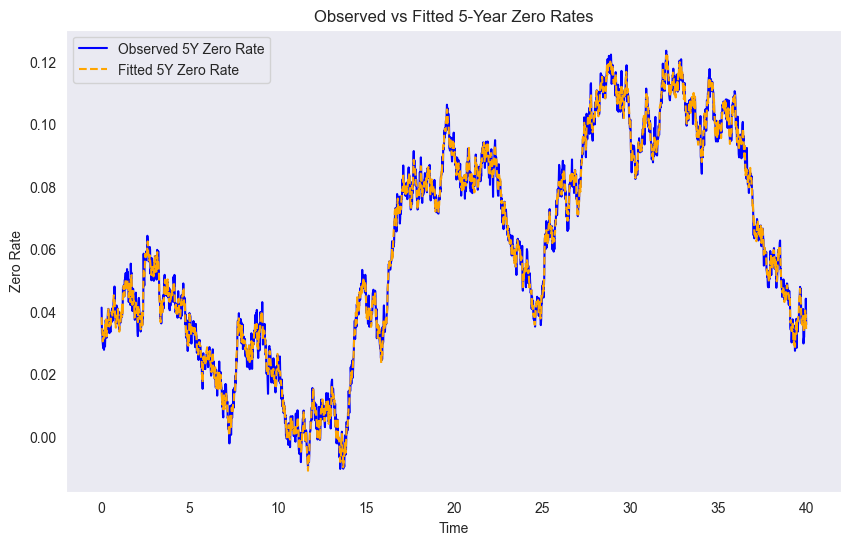

In [113]:
"""
Plot fitted vs. observed zero rates
"""

tenor = 5  # 5-year zero rate
plt.figure(figsize=(10, 6))
plt.plot(df_zero_rates.index, df_zero_rates[tenor], label=f'Observed {tenor}Y Zero Rate', color='blue')
plt.plot(df_zero_rates.index, fitted_zero_rates[:, np.where(time_to_maturities == tenor)[0][0]], label=f'Fitted {tenor}Y Zero Rate', color='orange', linestyle='--')
plt.title('Observed vs Fitted 5-Year Zero Rates')
plt.xlabel('Time')
plt.ylabel('Zero Rate')
plt.legend()
plt.grid()
plt.show()


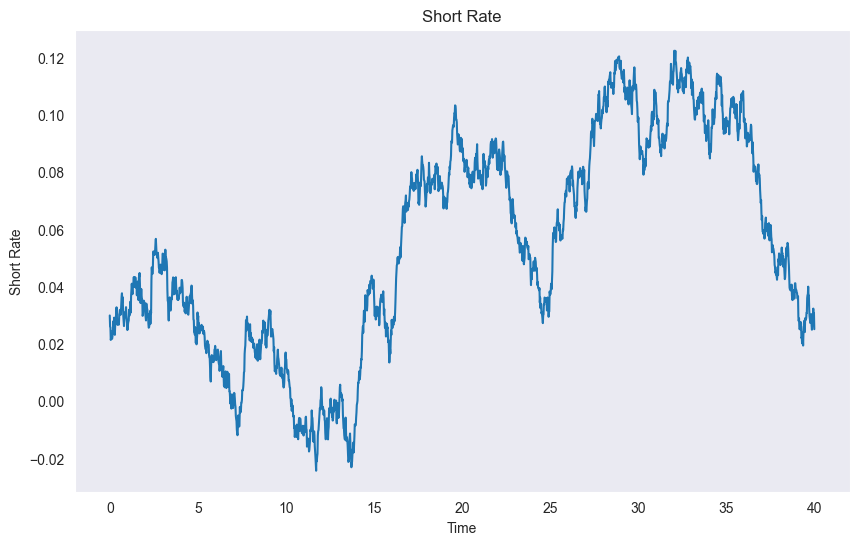

In [114]:
"""
Plot the evolution of the short rate
"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_zero_rates.index, short_rates)
ax.set_xlabel('Time')
ax.set_ylabel('Short Rate')
ax.set_title('Short Rate')
plt.grid()


## Modelling dynamics of equity returns

### Load data

In [115]:
dt = 1.0 / 52.0  # weekly time step

# load equity index data
df_equity_index = pd.read_csv('equity_index_data.csv', index_col=0)

# calculate log returns
df_equity_log_returns = np.log(df_equity_index / df_equity_index.shift(1)).dropna()

# calculate log excess returns using the short rate
df_equity_excess_log_returns = df_equity_log_returns - short_rates[:-1, np.newaxis] * dt

<Axes: >

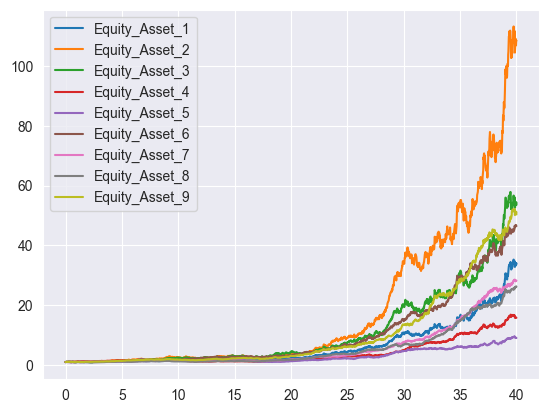

In [116]:
df_equity_index.plot()

In [117]:
df_equity_index.head()

,Equity_Asset_1,Equity_Asset_2,Equity_Asset_3,Equity_Asset_4,Equity_Asset_5,Equity_Asset_6,Equity_Asset_7,Equity_Asset_8,Equity_Asset_9
0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.01924,0.988885,1.001435,0.994491,1.011994,1.003262,0.996985,1.005525,0.993685,1.007656
0.03848,0.981553,0.990179,0.993028,1.018942,1.010574,0.999804,1.015449,0.995436,1.020513
0.05772,1.035196,1.048845,1.043311,1.034091,1.033471,1.003582,1.034376,1.009531,1.039956
0.07696,1.028358,1.055870,1.038925,1.052074,1.042718,1.026199,1.016618,1.010591,1.043440


In [118]:
df_equity_log_returns.mean(axis=0) * 52.0

Equity_Asset_1    0.088060
Equity_Asset_2    0.117227
Equity_Asset_3    0.099571
Equity_Asset_4    0.069038
Equity_Asset_5    0.055089
Equity_Asset_6    0.096006
Equity_Asset_7    0.083550
Equity_Asset_8    0.081708
Equity_Asset_9    0.098033
dtype: float64

In [119]:
df_equity_excess_log_returns.mean(axis=0) * 52.0

Equity_Asset_1    0.033634
Equity_Asset_2    0.062801
Equity_Asset_3    0.045145
Equity_Asset_4    0.014612
Equity_Asset_5    0.000663
Equity_Asset_6    0.041580
Equity_Asset_7    0.029124
Equity_Asset_8    0.027282
Equity_Asset_9    0.043607
dtype: float64

### Deciding on model for equity excess log returns

We check whether there is a significant relationship between equity excess log returns and the short rate by regressing the excess log returns on the short rate.

In [120]:
"""
Regress equity excess log returns on short rate
"""

X = np.vstack([np.ones(len(short_rates)-1), short_rates[:-1]]).T  # design matrix with intercept
y = df_equity_log_returns.values
betas = np.linalg.inv(X.T @ X) @ X.T @ y

df_betas = pd.DataFrame(betas, index=['Intercept', 'Short_Rate'], columns=df_equity_log_returns.columns)
df_betas


,Equity_Asset_1,Equity_Asset_2,Equity_Asset_3,Equity_Asset_4,Equity_Asset_5,Equity_Asset_6,Equity_Asset_7,Equity_Asset_8,Equity_Asset_9
Intercept,0.000507,0.000867,0.001031,-0.000188,0.000195,0.001064,-0.000135,-0.000027,0.000381
Short_Rate,0.021794,0.025499,0.016233,0.027839,0.015887,0.014380,0.031997,0.029360,0.027637


In [121]:
# expected beta if we should model excess returns
1 / 52

0.019230769230769232

The estimated betas indicate the sensitivity of each equity asset's log returns to the short rate. A significant beta would suggest that the short rate has a meaningful impact on the equity asset's returns. The coefficients are close to the time step `dt`, indicating that the returns could be modelled as excess returns over the short rate.

Next, we perform some informal tests of whether excess returns are reasonable risk drivers. You could include additional relevant formal statistical tests.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

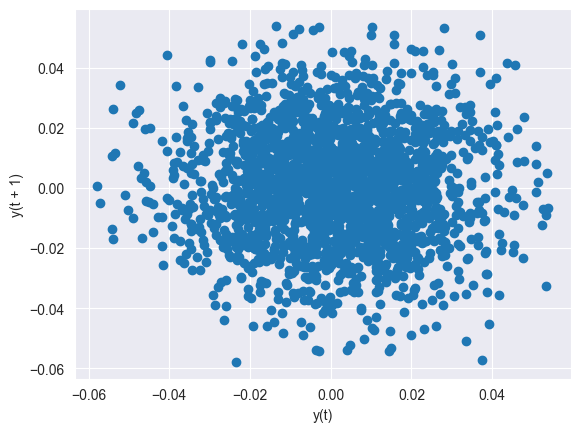

In [122]:
"""
Scatter plot the check "independence"
"""

asset = "Equity_Asset_1"

pd.plotting.lag_plot(df_equity_excess_log_returns[asset])


(0.0, 10.0)

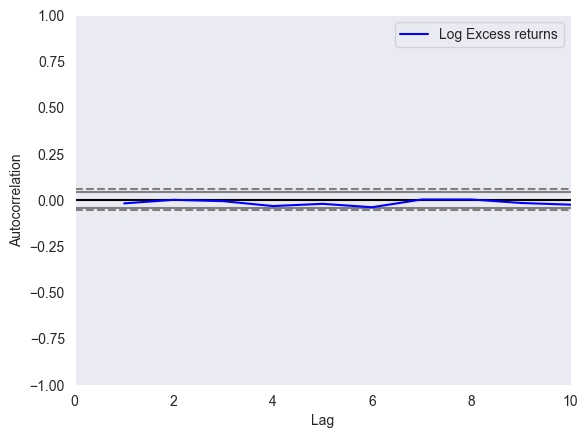

In [123]:
"""
Plot autocorrelation plot for serial dependence
"""

pd.plotting.autocorrelation_plot(df_equity_excess_log_returns[asset], label='Log Excess returns', color='blue')
plt.xlim([0,10])

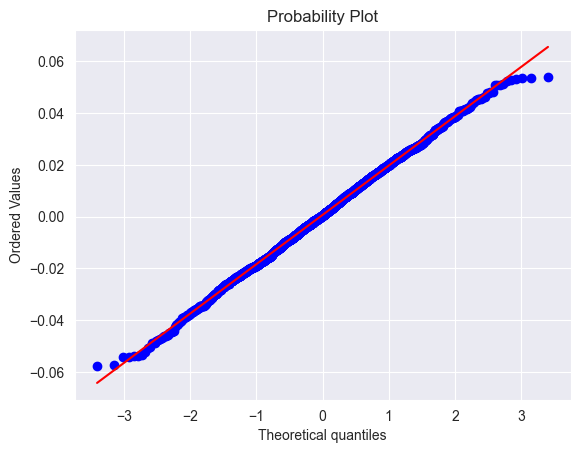

In [124]:
"""
QQ-plot for check for normality
"""

stats.probplot(df_equity_excess_log_returns[asset], dist='norm', plot=plt);

In [125]:
"""
JB test for normality
"""

jb_stat, p_value = stats.jarque_bera(df_equity_excess_log_returns[asset])
print(f"JB statistic: {jb_stat}, p-value: {p_value}")

JB statistic: 1.9909157117907235, p-value: 0.36955420323234395


Generally, the excess log return can be modelled as iid normal. I will simulate equity excess log-return based on this assumption.

### Estimate parameters of equity excess log return model

In [126]:
# calculate covariance matrix of log excess returns
cov_mat_excess_eq = np.cov(df_equity_excess_log_returns.T, ddof=1)
# calculate mean vector of log excess returns
mu_excess_eq = df_equity_excess_log_returns.mean().values
# calculate correlation matrix of log excess returns
corr_mat_excess_eq = moments.cov_to_corr_matrix(cov_mat_excess_eq)

In [127]:
mu_excess_eq * 52.0

array([0.0336338 , 0.06280061, 0.04514517, 0.0146122 , 0.00066306,
       0.04158012, 0.0291244 , 0.02728225, 0.04360693])

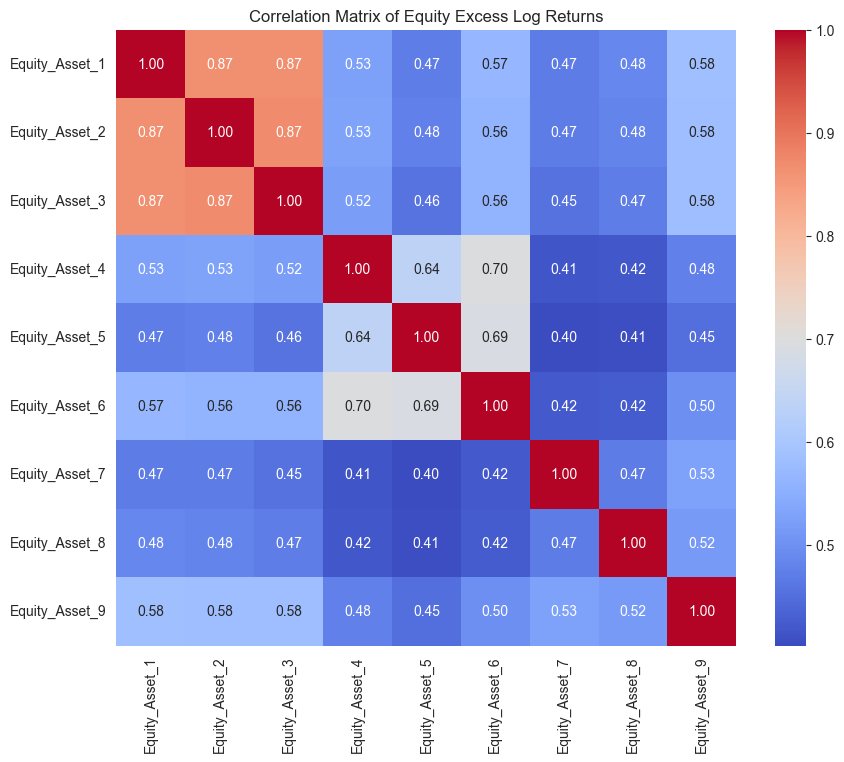

In [128]:
# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat_excess_eq, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=df_equity_excess_log_returns.columns, yticklabels=df_equity_excess_log_returns.columns)
plt.title('Correlation Matrix of Equity Excess Log Returns')
plt.show()

# <- we could implement factor model

In [129]:
"""
Check correlation between short rate changes and equity excess log returns
"""

def vasicek_residuals(short_rates: np.ndarray, theta, kappa) -> np.ndarray:

    mu_r = theta + (short_rates[:-1] - theta) * np.exp(-kappa * dt)

    return short_rates[1:] - mu_r

# create dataframe with vasick residual short rates and equity excess returns
df_invariants = df_equity_excess_log_returns.copy()
df_invariants['vasicke_residuals'] = vasicek_residuals(short_rates, theta_p_est, kappa_est)


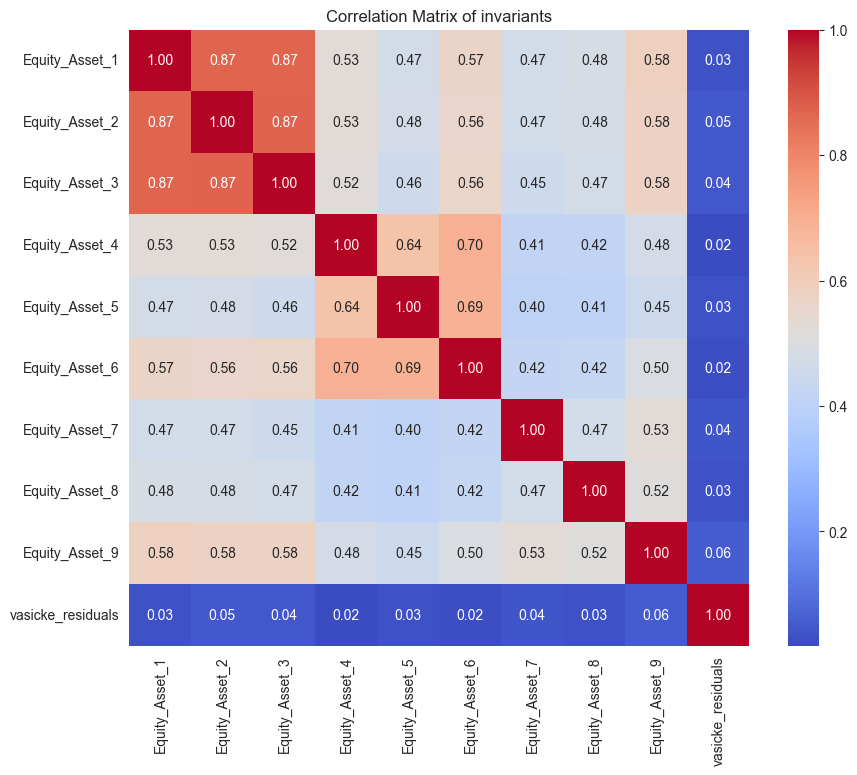

In [130]:
cov_mat_invariants = np.cov(df_invariants.T, ddof=1)
corr_mat_invariants = moments.cov_to_corr_matrix(cov_mat_invariants)

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat_invariants, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=df_invariants.columns, yticklabels=df_invariants.columns)
plt.title('Correlation Matrix of invariants')
plt.show()


I decide to simulate the short rate and log-excess returns independently. 

## Simulate PnL distribution at the investment horizon

### Simulate short rates, bank account and bullet bonds

In [131]:
esg = {} # empty dictionary to store results, "economic scenario generator"

In [132]:
"""
Helper functions
"""

def simulate_vasicek(initial_short_rate: float,
                     kappa: float,
                     theta: float,
                     sigma: float,
                     horizon: float,
                     dt: float = 1.0 / 12,
                     num_sim: int = 10000):
    """
    simulates short rate processes in a Vasicek setting until a given horizon

    Parameters
    ----------

    initial_short_rate:
        initial short rate
    kappa:
        speed of mean reversion.
    theta:
        long term mean of the short rate.
    sigma:
        volatility of the short rate.
    horizon:
        time until maturity/expiry (horizon).
    dt:
        increments in time
    num_sim:
        number of simulations.
    """
    std_rates = np.sqrt(sigma ** 2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))

    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate

    error_terms = np.random.normal(scale=std_rates, size=(num_sim, num_periods))

    for i in range(1, num_periods + 1):
        short_rates[:, i] = theta + (short_rates[:, i - 1] - theta) * np.exp(-kappa * dt) + error_terms[:, i - 1]

    return short_rates

def calculate_zero_coupon_price_vector(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                sigma: float):

    """
    Computes the zero coupon yield for a given maturity and short rate using the Vasicek model.

    Parameters
    ----------
    time_to_maturity:
        time to maturity of the zero coupon bond.
    initial_short_rate:
        initial short rate.
    kappa:
        speed of mean reversion.
    theta:
        long term mean of the short rate.
    sigma:
        volatility of the short rate.

    Returns
    -------
    zero_coupon_price:
        price of the zero coupon bond.
    """

    time_to_maturity = np.atleast_1d(time_to_maturity)
    initial_short_rate = np.atleast_1d(initial_short_rate)

    y_infty = theta- sigma ** 2 / (2 * kappa ** 2)

    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity - b) + sigma ** 2 / (4 * kappa) * b ** 2

    return np.exp(- a[:, None] - b[:, None] * initial_short_rate[None, :])


In [133]:
"""
Simulate short rates at the investment horizon
"""

dt = 1.0 / 52.0  # weekly time step
horizon = 1.0  # 1 year
num_sim = 100_000
time_points = np.arange(0, horizon + dt, dt)
num_per = int(horizon / dt)

short_rates_sim = simulate_vasicek(initial_short_rate=short_rates[-1],
                                   kappa=kappa_est,
                                   theta=theta_p_est,
                                   sigma=sigma_est,
                                   horizon=horizon,
                                   dt=dt,
                                   num_sim=num_sim)

esg['SHORT_RATE'] = short_rates_sim

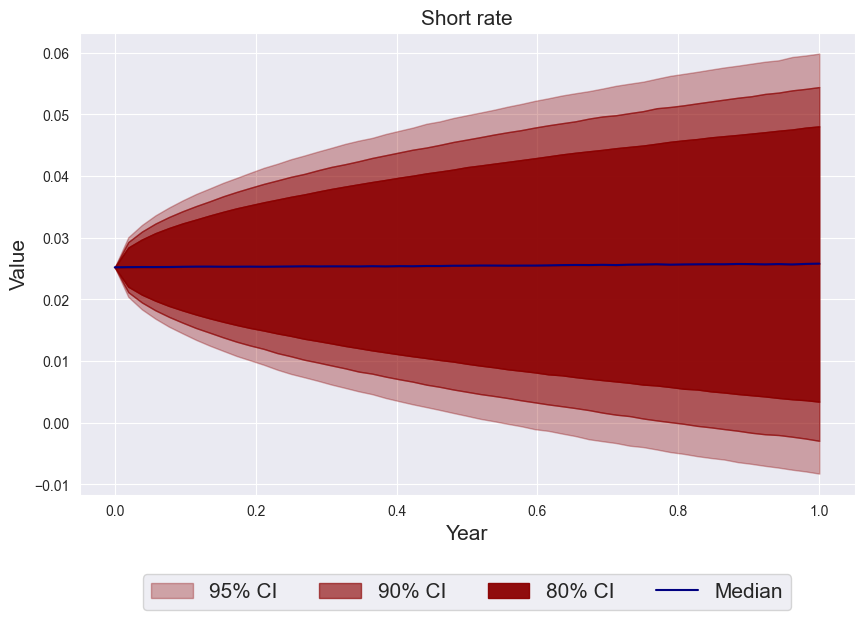

In [134]:
# calculate percentiles
percentiles = np.percentile(esg['SHORT_RATE'], [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color='darkred',
          color_median='navy',
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Value", size=15)
ax.set_title("Short rate", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

In [135]:
"""
Bank account
"""

bank_account_values = np.c_[np.ones(num_sim), np.exp(np.cumsum(short_rates_sim[:, :-1] * dt, axis=1))]
esg['BANK_ACCOUNT'] = bank_account_values # total return index of bank account

In [136]:
esg['BANK_ACCOUNT'].shape

(100000, 53)

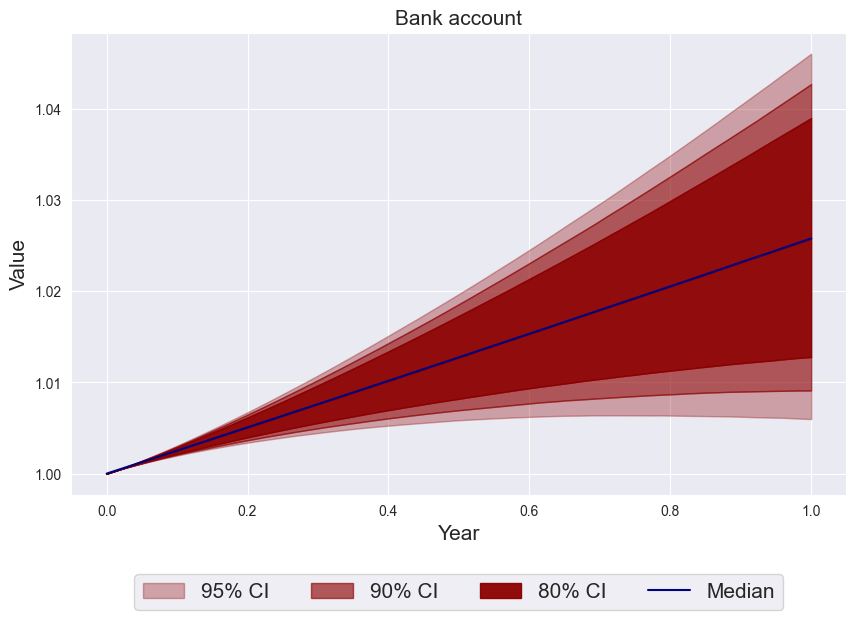

In [137]:
# calculate percentiles
percentiles = np.percentile(esg['BANK_ACCOUNT'], [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color='darkred',
          color_median='navy',
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Value", size=15)
ax.set_title("Bank account", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

In [138]:
"""
Simulate total return index of bullet bonds
"""

bullet_cash_flow_time_points = cash_flow_time_points[1:]  # exclude 3M ZCB

# allocate tri for bullet bonds
all_bullet_bonds = np.empty((num_sim, bullet_bond_cash_flow_matrix.shape[0], bank_account_values.shape[1]))

for i, t in enumerate(time_points):
    # calculate time to maturities
    time_to_maturities = bullet_cash_flow_time_points - t
    time_to_maturities = np.where(time_to_maturities < 0, 0.0, time_to_maturities)

    # calculate zero coupon prices at time t
    zero_coupon_prices = calculate_zero_coupon_price_vector(time_to_maturities,
                                                            short_rates_sim[:, i],
                                                            kappa_est,
                                                            theta_q_est,
                                                            sigma_est)

    # calculate bond prices at time t
    bond_prices = bullet_bond_cash_flow_matrix @ zero_coupon_prices

    # store bond prices
    all_bullet_bonds[:, :, i] = bond_prices.T

for i in range(1, 11, 1):
    esg[f'BULLET_BOND_{i}Y'] = all_bullet_bonds[:, i - 1, :]

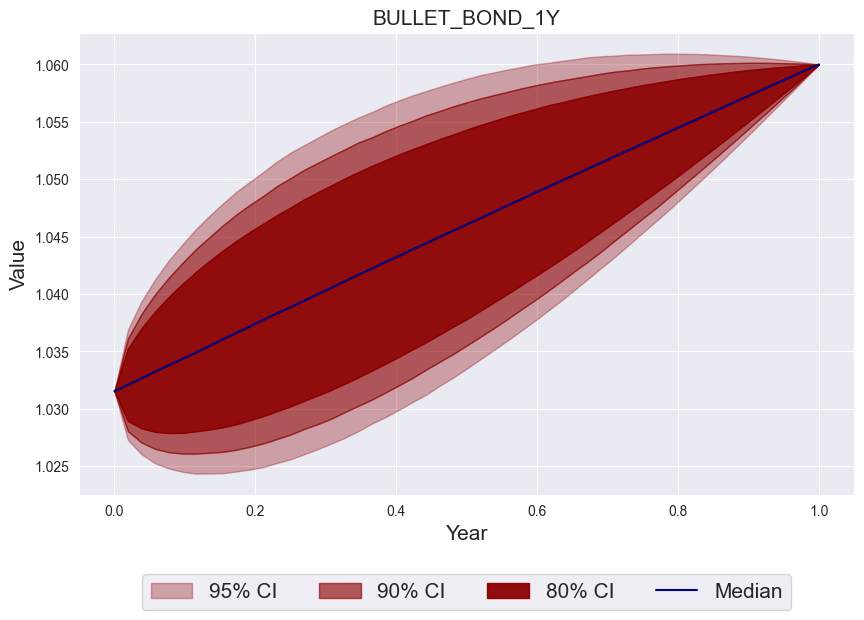

In [139]:
# calculate percentiles
ticker = 'BULLET_BOND_1Y'
percentiles = np.percentile(esg[ticker], [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color='darkred',
          color_median='navy',
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Value", size=15)
ax.set_title(ticker, size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

### Simulate equities

In [140]:
# simulate equity excess log returns
equity_log_excess_returns_sim = np.random.multivariate_normal(mean=mu_excess_eq,
                                                              cov=cov_mat_excess_eq,
                                                              size=(num_sim, num_per))

# calculate equity log returns by adding short rates
equity_log_returns_sim = equity_log_excess_returns_sim + short_rates_sim[:, :-1, np.newaxis] * dt

# calculate equity index
equity_index_sim = np.ones((num_sim, num_per + 1, mu_excess_eq.shape[0]), dtype=float)
equity_index_sim[:, 1:, :] = np.exp(np.cumsum(equity_log_returns_sim, axis=1))

# store in dictionary
for i in range(mu_excess_eq.shape[0]):
    esg[f'EQUITY_ASSET_{i+1}'] = equity_index_sim[:, :, i]


In [141]:
equity_log_excess_returns_sim

array([[[-0.00700794,  0.01106134, -0.00061354, ...,  0.0031901 ,
         -0.00756364, -0.00818753],
        [ 0.03162102,  0.02701773,  0.04328953, ...,  0.00034964,
          0.00808119,  0.00330086],
        [ 0.00168158, -0.00806635,  0.01042561, ..., -0.00486988,
          0.00244496, -0.00754144],
        ...,
        [-0.01995649, -0.00961113, -0.01554729, ..., -0.01256387,
         -0.00196129, -0.0019567 ],
        [-0.00504877,  0.00325024,  0.01110736, ..., -0.00086781,
         -0.0146375 , -0.00780331],
        [ 0.01997207,  0.0145351 ,  0.02454475, ...,  0.00780199,
          0.00785896,  0.01113253]],

       [[-0.01749432, -0.01235878, -0.03121708, ..., -0.01513883,
          0.02222172, -0.01217842],
        [-0.01249214, -0.01774645, -0.01402355, ..., -0.00845208,
         -0.02265912, -0.0067522 ],
        [ 0.01378948, -0.0011279 ,  0.01147402, ..., -0.00735829,
         -0.01331583,  0.01240113],
        ...,
        [-0.00327374,  0.02225123,  0.01877461, ..., -

In [142]:
esg.keys()

dict_keys(['SHORT_RATE', 'BANK_ACCOUNT', 'BULLET_BOND_1Y', 'BULLET_BOND_2Y', 'BULLET_BOND_3Y', 'BULLET_BOND_4Y', 'BULLET_BOND_5Y', 'BULLET_BOND_6Y', 'BULLET_BOND_7Y', 'BULLET_BOND_8Y', 'BULLET_BOND_9Y', 'BULLET_BOND_10Y', 'EQUITY_ASSET_1', 'EQUITY_ASSET_2', 'EQUITY_ASSET_3', 'EQUITY_ASSET_4', 'EQUITY_ASSET_5', 'EQUITY_ASSET_6', 'EQUITY_ASSET_7', 'EQUITY_ASSET_8', 'EQUITY_ASSET_9'])

In [143]:
equity_log_excess_returns_sim.shape

(100000, 52, 9)

In [144]:
moments.calculate_correlation(esg['BULLET_BOND_2Y'][:, -1], esg['BULLET_BOND_3Y'][:, -1])

np.float64(0.9999365413216491)

### Calculate PnL distribution at the investment horizon

In [145]:
# get list of investable assets
assets_names = list(esg.keys())[1:]

# obtain initial prices
initial_prices = np.array([esg[asset][0, 0] for asset in assets_names])

# allocate array for PnL
pnl_matrix = np.empty((num_sim, len(assets_names)))

# calculate PnL for each asset
for i, asset in enumerate(assets_names):
    final_prices = esg[asset][:, -1]
    pnl_matrix[:, i] = final_prices - initial_prices[i]

In [146]:
# equal-weighted portfolio
h_eq = (100_000_000 / len(assets_names)) / initial_prices  # invest 100 million equally across all assets

# calculate PnL for equal-weighted portfolio
pnl_eq = pnl_matrix @ h_eq

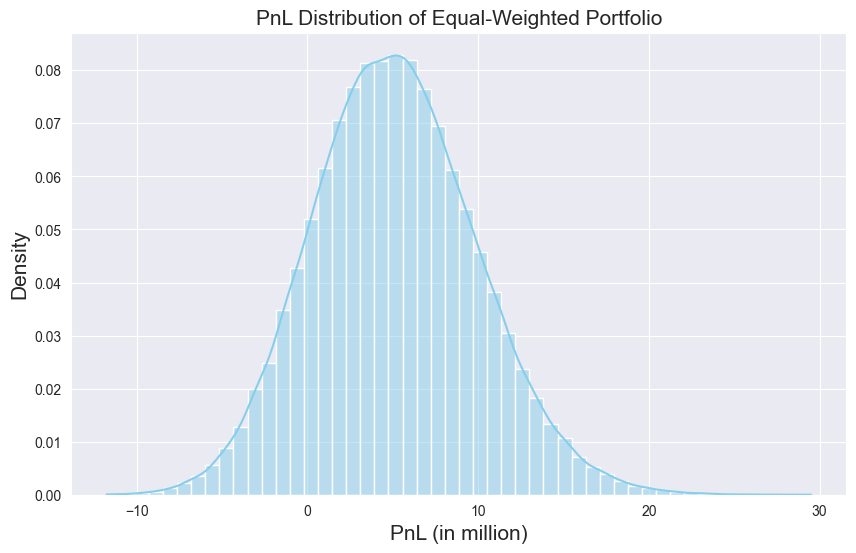

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(pnl_eq / 1e6, bins=50, kde=True,
                color='skyblue', stat='density', ax=ax)
ax.set_title('PnL Distribution of Equal-Weighted Portfolio', size=15)
ax.set_xlabel('PnL (in million)', size=15)
ax.set_ylabel('Density', size=15);

## Portfolio optimization

In [148]:
wealth = 1  # total wealth to invest

In [149]:
"""
Helper functions
"""


# Define a function to optimize portfolio weights using CVaR minimization.
def calculate_mean_cvar_optimization(pnl_matrix: np.ndarray,
                                     beta: float,
                                     probs: None,
                                     initial_prices: np.ndarray,
                                     pnl_target: float = None,
                                     wealth: float = 100_000_000,
                                     solver: str = None,
                                     verbose: bool = False) -> np.ndarray:

    """
    Optimize portfolio weights using CVaR minimization. The optimization problem can handle optional return constraints.

    Parameters
    ----------
    pnl_matrix : np.ndarray
        Simulated returns of shape (num_simulations, num_assets).
    beta : float
        Confidence level for CVaR (e.g., 0.95 for 95% CVaR).
    initial_prices : np.ndarray
        Initial prices of the assets.
    probs : np.ndarray or None
        Probabilities associated with each simulation. If None, equal probabilities are assumed.
    pnl_target : float or None
        Target return for the portfolio. If None, no return constraint is applied.
    verbose : bool
        If True, print solver output.

    Returns
    -------
    h : np.ndarray
        Optimized portfolio holdings.
    alpha : float
        Value at Risk at the specified confidence level.
    """

    if solver is None:
        solver = cp.SCS

    num_assets = pnl_matrix.shape[1]
    num_sim = pnl_matrix.shape[0]

    if probs is None:
        probs = np.ones(num_sim) / num_sim

    # Define variables
    h = cp.Variable(num_assets)  # portfolio weights
    u = cp.Variable(num_sim)  # auxiliary variables for CVaR
    alpha = cp.Variable()  # Value at Risk variable

    # Define the objective function (minimize CVaR)
    objective = cp.Minimize(alpha + (1 / (1 - beta)) * cp.sum(cp.multiply(probs, u)))

    # Define constraints
    constraints = [
        cp.sum(h @ initial_prices) == wealth,  # holdings multiplied by initial prices sum to wealth
        h[0] >= -wealth * 0.2,  # max shorting constraint
        h[1:] >= 0,          # no short selling for all but bank account
        u >= 0,          # auxiliary variables non-negative
        u >= -pnl_matrix @ h - alpha  # definition of u
    ]

    if pnl_target is not None:
        constraints.append(cp.sum(cp.multiply(probs, pnl_matrix @ h)) >= pnl_target)

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=verbose, solver=solver)

    return h.value, alpha.value

In [150]:
avg_pnl = np.average(pnl_matrix, axis=0) * wealth
min_avg_pnl = (avg_pnl / initial_prices).min()
max_avg_pnl = (avg_pnl / initial_prices).max()

In [151]:
max_avg_pnl / wealth

np.float64(0.1054147951708051)

In [152]:
pnl_targets = np.linspace(min_avg_pnl, max_avg_pnl, 20)

h_optimal = np.array([calculate_mean_cvar_optimization(pnl_matrix,
                                                       beta=0.95,
                                                       initial_prices=initial_prices,
                                                       probs=None,
                                                       pnl_target=target,
                                                       wealth=wealth,
                                                       verbose=False)[0] for target in pnl_targets])


In [153]:
pd.DataFrame(h_optimal, columns=assets_names)

,BANK_ACCOUNT,BULLET_BOND_1Y,BULLET_BOND_2Y,BULLET_BOND_3Y,BULLET_BOND_4Y,BULLET_BOND_5Y,BULLET_BOND_6Y,BULLET_BOND_7Y,BULLET_BOND_8Y,BULLET_BOND_9Y,BULLET_BOND_10Y,EQUITY_ASSET_1,EQUITY_ASSET_2,EQUITY_ASSET_3,EQUITY_ASSET_4,EQUITY_ASSET_5,EQUITY_ASSET_6,EQUITY_ASSET_7,EQUITY_ASSET_8,EQUITY_ASSET_9
0,0.000016,9.693997e-01,7.527899e-06,5.253146e-06,3.352309e-06,1.829400e-06,6.346217e-07,-2.755400e-07,-9.466668e-07,-1.422142e-06,-0.000002,-3.799025e-09,5.082398e-09,3.273748e-09,-5.908491e-09,-3.132099e-10,-4.696971e-09,-1.663892e-08,-1.510740e-08,-6.973338e-09
1,-0.041631,9.560052e-01,-1.867352e-08,-2.755419e-08,-3.184104e-08,-3.216791e-08,-2.904677e-08,-2.308117e-08,-1.484441e-08,-4.804241e-09,0.007712,-1.154312e-05,4.827918e-03,-1.051701e-05,6.885710e-06,7.356483e-06,8.267920e-03,8.392700e-03,2.191526e-03,2.279790e-02
2,-0.111453,9.315752e-01,1.097619e-07,8.775702e-08,6.684847e-08,4.809748e-08,3.160444e-08,1.743921e-08,5.536336e-09,-4.307302e-09,0.020955,9.013732e-06,1.306322e-02,7.998389e-06,3.023816e-06,5.224845e-06,2.243944e-02,2.279281e-02,5.982504e-03,6.171949e-02
3,-0.182092,9.082282e-01,1.392823e-07,2.503083e-07,3.083349e-07,3.239478e-07,3.053854e-07,2.607263e-07,1.969366e-07,1.193398e-07,0.034091,-9.926370e-06,2.138219e-02,1.944688e-05,5.546690e-06,-2.657620e-06,3.654263e-02,3.706770e-02,9.703072e-03,1.006901e-01
4,-0.200000,8.295205e-01,9.009114e-09,2.541457e-08,3.425413e-08,3.704674e-08,3.506363e-08,2.948508e-08,2.135511e-08,1.137311e-08,0.051004,5.026916e-06,3.008474e-02,2.903443e-06,-9.130249e-07,4.808443e-06,5.081863e-02,5.149748e-02,1.340760e-02,1.389213e-01
5,-0.200000,7.321568e-01,5.726848e-09,-2.158489e-08,-3.882546e-08,-4.759872e-08,-4.939387e-08,-4.567294e-08,-3.771906e-08,-2.661462e-08,0.069167,-3.147703e-06,3.864610e-02,-1.302426e-05,4.449353e-07,-1.348745e-05,6.517968e-02,6.586060e-02,1.671562e-02,1.775862e-01
6,-0.200000,6.343016e-01,5.424691e-08,7.148881e-08,7.842775e-08,7.737778e-08,6.991947e-08,5.769719e-08,4.202210e-08,2.393941e-08,0.087576,5.052561e-06,4.670931e-02,-5.680054e-06,6.830454e-07,4.776804e-06,7.962841e-02,8.039304e-02,2.013400e-02,2.165252e-01
7,-0.200000,5.368549e-01,2.326491e-09,1.203357e-09,4.500702e-10,2.159445e-11,-1.529491e-10,-1.331961e-11,3.421906e-10,8.264435e-10,0.106072,-4.905357e-06,5.522245e-02,-4.101791e-06,2.974917e-06,-1.780586e-05,9.436426e-02,9.473464e-02,2.313967e-02,2.548719e-01
8,-0.200000,4.387587e-01,8.854971e-08,6.622037e-08,4.736192e-08,3.228058e-08,2.037311e-08,1.127311e-08,4.515585e-09,-2.630055e-10,0.124719,-5.430176e-06,6.352427e-02,1.677166e-05,-4.389402e-07,1.253553e-05,1.090255e-01,1.099329e-01,2.637842e-02,2.928313e-01
9,-0.199999,3.413838e-01,4.244013e-07,3.790370e-07,3.258759e-07,2.698757e-07,2.122753e-07,1.548016e-07,9.870332e-08,4.442422e-08,0.143183,-7.247792e-06,7.245904e-02,8.049747e-06,1.601021e-05,1.275218e-05,1.232289e-01,1.244066e-01,2.955372e-02,3.309130e-01


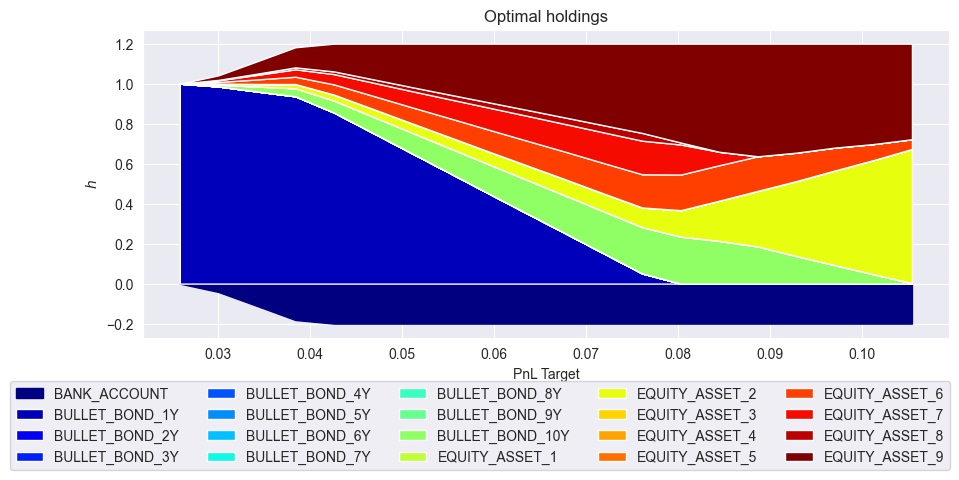

In [154]:
"""
Optimal holdings
"""

cmap = plt.get_cmap('jet')
asset_colors = cmap(np.linspace(0, 1, 20))

fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(pnl_targets, h_optimal[:, 0], color=asset_colors[0], label=assets_names[0])
ax.stackplot(pnl_targets, (h_optimal[:, 1:] * initial_prices[1:]).T, colors=asset_colors[1:], labels=assets_names[1:])
ax.legend(ncol=5, bbox_to_anchor=(1.01, -0.12))
ax.set_xlabel('PnL Target')
ax.set_ylabel('$h$')
ax.set_title('Optimal holdings')
plt.tight_layout()
plt.savefig('optimal_holdings.png', dpi=300)

In [174]:
# calculate PnL for optimal portfolios
pnl_matrix_opt = pnl_matrix @ h_optimal.T

# calculate expected PnL
opt_mean_pnl = np.average(pnl_matrix_opt, axis=0) # avg_pnl @ h_optimal.T

# calculate CVaR(5%) for optimal portfolios
opt_cvar_pnl = np.array([-rm.calculate_conditional_value_at_risk(pnl_matrix_opt[:, i], 0.05) for i in range(len(pnl_targets))])

# calculate mean pnl and cvar for assets for 1 invested
asset_mean_pnl = avg_pnl / initial_prices

asset_cvar = np.array([-rm.calculate_conditional_value_at_risk(pnl_matrix[:, i] / initial_prices[i], 0.05) for i in range(len(assets_names))])

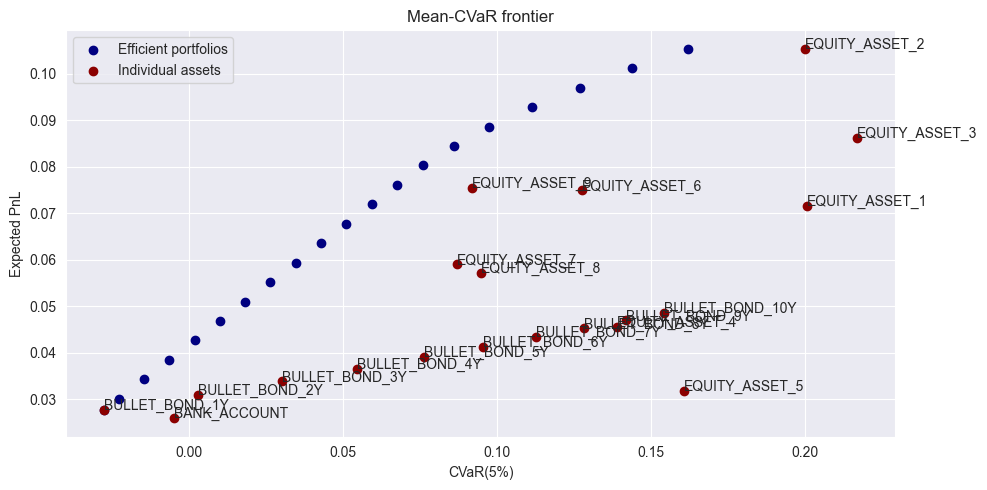

In [178]:
"""
Plot the mean-CVaR frontier with the individual assets
"""

fig, ax = plt.subplots(figsize=(10, 5))

# plot efficient portfolios
ax.scatter(opt_cvar_pnl, opt_mean_pnl, color="navy", linestyle="-", label="Efficient portfolios")
ax.set_xlabel('CVaR(5%)')
ax.set_ylabel('Expected PnL')
ax.set_title('Mean-CVaR frontier')

# plot invidual assts
ax.scatter(asset_cvar, asset_mean_pnl, color="darkred", label="Individual assets")

# add names of individual assets
for i, asset in enumerate(assets_names):
    ax.annotate(asset, (asset_cvar[i], asset_mean_pnl[i]))


ax.legend()


plt.tight_layout()


In [121]:
pd.DataFrame(data=h_optimal, columns=assets_names).round(2)

,BANK_ACCOUNT,BULLET_BOND_1Y,BULLET_BOND_2Y,BULLET_BOND_3Y,BULLET_BOND_4Y,BULLET_BOND_5Y,BULLET_BOND_6Y,BULLET_BOND_7Y,BULLET_BOND_8Y,BULLET_BOND_9Y,BULLET_BOND_10Y,EQUITY_ASSET_1,EQUITY_ASSET_2,EQUITY_ASSET_3,EQUITY_ASSET_4,EQUITY_ASSET_5,EQUITY_ASSET_6,EQUITY_ASSET_7,EQUITY_ASSET_8,EQUITY_ASSET_9
0,0.00,0.97,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.00,-0.0,0.00,0.0,-0.0,-0.0,-0.00,-0.00,-0.00,-0.00
1,-0.05,0.96,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.01,0.01,0.00,0.02
2,-0.13,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,-0.0,0.01,0.0,0.0,0.0,0.02,0.03,0.01,0.06
3,-0.20,0.92,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.03,-0.0,0.02,-0.0,-0.0,0.0,0.03,0.04,0.01,0.10
4,-0.20,0.83,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.05,-0.0,0.03,0.0,0.0,0.0,0.05,0.06,0.01,0.13
5,-0.20,0.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,-0.0,0.04,0.0,-0.0,0.0,0.06,0.07,0.02,0.17
6,-0.20,0.63,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.09,0.0,0.05,-0.0,0.0,0.0,0.07,0.09,0.02,0.21
7,-0.20,0.53,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.06,-0.0,0.0,0.0,0.09,0.11,0.02,0.25
8,-0.20,0.43,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.13,-0.0,0.07,0.0,-0.0,0.0,0.10,0.12,0.03,0.28
9,-0.20,0.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.0,0.08,0.0,0.0,0.0,0.11,0.14,0.03,0.32


One could add tables with summary statistics of the portfolios, calculate risk contribtions, etc.

## Sources of uncertainty

We can think of a number of sources of uncertainty regarding the data generating process, e.g.

- Model uncertainty  (We do not appy the correct model, e.g. we use a three-factor model instead of the true one-factor Vasicek model)
- Estimation uncertainty regarding the model parameters
- Monte Carlo uncertainty coming from the fact that we need to simulate the one year PnL distribution

### Estimation uncertainty

An important point regarding estimation uncertainty is that the long time span only give limited information about the expected return / pnl, while we will obtain a good estimate of the volatility. If the log (excess) return is iid normally distributed, then we know that the sample mean has the distribution
$$
\bar{X} \sim N(\mu_W, \sigma_w^2 / T_w)
$$
where $T_w$ is the sample size, here equal to $40 \times 52$ weeks. Thus, given the large amount of observation the variance of the sample mean for weekly log-returns is small. However, the estimator for the yearly expected return is
$$
52 \cdot \bar{X} \sim N(52 \cdot \mu, 52^2 \cdot \sigma^2 / T) = N(\mu_a, \sigma_a^2 / T_a)
$$
Exactly the same as if we just used the 40 annual log-returns. Thus, with a $\sigma_a = 0.2$, we would have standard deviation $\sqrt{0.2^2 / 40} \approx 3.2\%$. Thus, the observed difference in total log-return may just be a result of randomness and not a statistical difference.

On the contrary, it can be shown that the confidence interval for the standard deviation does get narrower if we increase the sampling frequency, for example by working with monthly returns instead of annual returns. With more frequent observations we can better estimate the variance and standard deviation, but not the mean. Thus, we expect much less estimation uncertainty about the standard deviation than the mean given the assumption about i.i.d. normal log-excess returns.

We can address the estimation uncertainty by using numerous techniques, e.g.

- allocation constraints
- shrinkage (for the expectation in our case and in particular for equities)


On potential way of evaluating the consequences of estimation uncertainty is to bootstrap or simulate datasets assuming that the estimated data generating process is correct, repeat the estimation and portfolio construction and plot the distribution of weights. This will be a computational extensive task.

### Monte Carlo uncertainty

It is important to use enough simulations to introduce too much monte carlo uncertainty. I will expect people to use at leat 10.000 scenarios.

## Subjective views in the asset allocation process

We would like to implement a view that stress test the portfolio choice. We have identified potentially poor estimates for expected equity return as a source of non-robustness. One may identify some clustering in the correlation matrix of excess log-returns. I will implement as view stating that the volatilities and expectations are identical for equity asset 1, 2, 3, and equity asset 4, 5, 6, and equity asset 7, 8, 9.

This could potentially lead to more diversified equity allocation. We can think of this as a way of stress testing assumptions for more robust portfolio outcomes.

In [197]:
std_pnl = np.std(pnl_matrix, axis=0)

"""
Views
"""

view_list = []

# equal mean 1, 2, 3
avg_123 = avg_pnl[-9:-6].mean()
std_123 = std_pnl[-9:-6].std()

view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -9], avg_123))
view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -8], avg_123))
view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -7], avg_123))

view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -9], avg_123, std_123))
view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -8], avg_123, std_123))
view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -7], avg_123, std_123))

# equal mean 1, 2, 3
avg_456 = avg_pnl[-6:-3].mean()
std_456 = std_pnl[-6:-3].std()

view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -6], avg_456))
view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -5], avg_456))
view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -4], avg_456))

view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -6], avg_456, std_456))
view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -5], avg_456, std_456))
view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -4], avg_456, std_456))

# equal mean 1, 2, 3
avg_789 = avg_pnl[-3:].mean()
std_789 = std_pnl[-3:].std()

view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -3], avg_789))
view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -2], avg_789))
view_list.append(ffv.MeanView('EQ', pnl_matrix[:, -1], avg_789))

view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -3], avg_789, std_789))
view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -2], avg_789, std_789))
view_list.append(ffv.VolatilityView('EQ', pnl_matrix[:, -1], avg_789, std_789))

# calculate view probs
view_solver = ffv.ProbabilitySolver(np.repeat(1 / num_sim, num_sim), view_list)
view_probs = prob_solver.minimize_entropy()


# number of effective scenarios
ffv.effective_sample_size_entropy(view_probs, relative=True)

np.float64(0.7536154182556158)

In [198]:
view_avg_pnl = np.average(pnl_matrix, axis=0, weights=view_probs) * wealth
view_min_avg_pnl = (view_avg_pnl / initial_prices).min()
view_max_avg_pnl = (view_avg_pnl / initial_prices).max()

In [199]:
pnl_targets = np.linspace(view_min_avg_pnl, view_max_avg_pnl, 20)

h_optimal = np.array([calculate_mean_cvar_optimization(pnl_matrix,
                                                       beta=0.95,
                                                       initial_prices=initial_prices,
                                                       probs=view_probs,
                                                       pnl_target=target,
                                                       wealth=wealth,
                                                       verbose=False)[0] for target in pnl_targets])

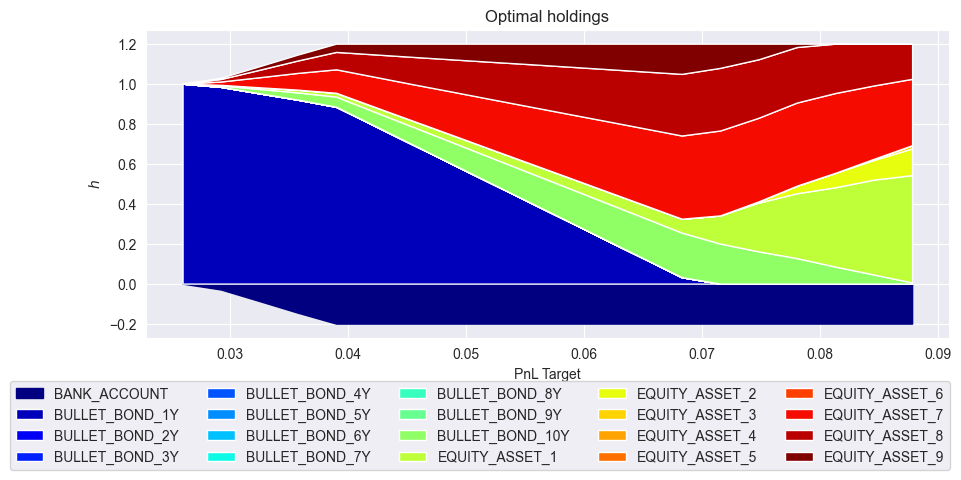

In [200]:
"""
Optimal holdings
"""

cmap = plt.get_cmap('jet')
asset_colors = cmap(np.linspace(0, 1, 20))

fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(pnl_targets, h_optimal[:, 0], color=asset_colors[0], label=assets_names[0])
ax.stackplot(pnl_targets, (h_optimal[:, 1:] * initial_prices[1:]).T, colors=asset_colors[1:], labels=assets_names[1:])
ax.legend(ncol=5, bbox_to_anchor=(1.01, -0.12))
ax.set_xlabel('PnL Target')
ax.set_ylabel('$h$')
ax.set_title('Optimal holdings')
plt.tight_layout()
plt.savefig('optimal_holdings_with_views.png', dpi=300)

In [201]:
# calculate PnL for optimal portfolios
pnl_matrix_opt = pnl_matrix @ h_optimal.T

# calculate expected PnL
opt_mean_pnl = np.average(pnl_matrix_opt, axis=0, weights=view_probs) # avg_pnl @ h_optimal.T

# calculate CVaR(5%) for optimal portfolios
opt_cvar_pnl = np.array([-rm.calculate_conditional_value_at_risk(pnl_matrix_opt[:, i], 0.05, probs=view_probs) for i in range(len(pnl_targets))])

# calculate mean pnl and cvar for assets for 1 invested
asset_mean_pnl = view_avg_pnl / initial_prices

asset_cvar = np.array([-rm.calculate_conditional_value_at_risk(pnl_matrix[:, i] / initial_prices[i], 0.05, probs=view_probs) for i in range(len(assets_names))])

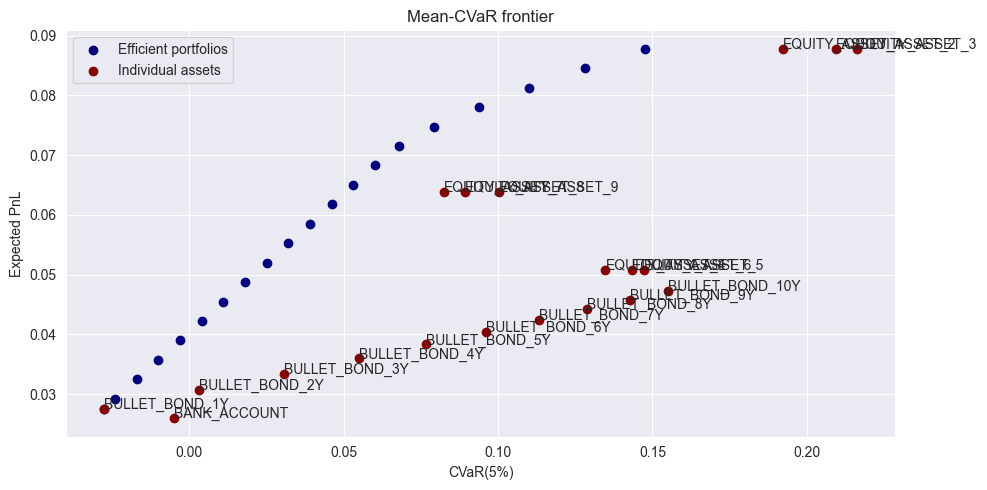

In [202]:
"""
Plot the mean-CVaR frontier with the individual assets
"""

fig, ax = plt.subplots(figsize=(10, 5))

# plot efficient portfolios
ax.scatter(opt_cvar_pnl, opt_mean_pnl, color="navy", linestyle="-", label="Efficient portfolios")
ax.set_xlabel('CVaR(5%)')
ax.set_ylabel('Expected PnL')
ax.set_title('Mean-CVaR frontier')

# plot invidual assts
ax.scatter(asset_cvar, asset_mean_pnl, color="darkred", label="Individual assets")

# add names of individual assets
for i, asset in enumerate(assets_names):
    ax.annotate(asset, (asset_cvar[i], asset_mean_pnl[i]))


ax.legend()
plt.tight_layout()
